# Illegal zoning
_they made the character of our neighboorhoods illegal_

Waltham, like a [lot](https://cityobservatory.org/the-illegal-city-of-somerville/) of [other](https://www.nytimes.com/interactive/2016/05/18/upshot/which-buildings-in-manhattan-couldnt-be-built-again-today.html) cities with zoning codes, has a bit of a silly problem.
You see, the zoning is so restrictive in some places, that the existing structures could not be rebuilt.
Everything would have to go through a special permit, which is time consuming and expensive. You can imagine a lot of people
wouldn't even bother and just build where the zoning is easier.

What's the scale of the problem?

In this notebook, I'll load GIS shapefiles data (some from MassGIS, some from the city) try to determine where Waltham has this issue. Some of these violations can only be confirmed by surveying,
so I'll only tackle the simpler ones here.

In [1]:

import pandas as pd
import folium
from folium.plugins import Search
import os
import json
import geopandas as geo_pd
import seaborn as sns
from matplotlib import pyplot as plt

# data fetching
from data.connect_db import get_db

%matplotlib inline

# constants
from waltham.constants import SQ_FT_PER_ACRE, FT_PER_STORY

ACRE_TO_M2 = 4046.86

con = get_db()


In [2]:
# some constants
PARCEL_SIZE_TOO_SMALL = "parcel_size_too_small"
STORIES_HIGH = "stories_high"
LOT_COVERAGE_HIGH = "lot_coverage_too_high"
FAR_HIGH = "far_high"
TOO_MANY_UNITS_PER_ACRE = "too_many_units_per_acre"
ANY_VIOLATIONS = "any_violations"

PARCEL_AREA_ACRE = "PARCEL_AREA_ACRE"
BLDG_FOOTPRINT_ACRE = "BLDG_FOOTPRINT_ACRE"

## Load shapefiles for buildings, zones, and parcels as well as the tax assessments data

In [3]:

query = """
select
    *
from
    "M308TaxPar_CY25_FY25"
"""

property_shapefiles_df = geo_pd.read_postgis(query, con)

# filter out right of way and water etc. property types
property_shapefiles_df = property_shapefiles_df[property_shapefiles_df["POLY_TYPE"] == "FEE"]
property_shapefiles_df = property_shapefiles_df[["LOC_ID", "geom", "SHAPE_Area"]]
property_shapefiles_df.rename(columns={"SHAPE_Area": PARCEL_AREA_ACRE}, inplace=True)

# MassGIS data is in m^2
property_shapefiles_df[PARCEL_AREA_ACRE] = property_shapefiles_df[PARCEL_AREA_ACRE] / ACRE_TO_M2

query = """
select
    *
from
    "M308Assess_CY25_FY25"
"""

assessments_df = pd.read_sql(query, con)
assessments_df = assessments_df[["LOC_ID", "SITE_ADDR", "YEAR_BUILT", "UNITS", "RES_AREA", "STORIES", "USE_CODE", "BLD_AREA"]]

### Data cleaning
See comments for reasoning

In [4]:
# use codes should be ints, since they're grouped by hundreds typically
assessments_df["USE_CODE"] = assessments_df["USE_CODE"].astype(int)

# and filter out anything that's not housing
# ref. https://www.mass.gov/doc/property-type-classification-codes-non-arms-length-codes-and-sales-report-spreadsheet/download
assessments_df = assessments_df[assessments_df["USE_CODE"] < 200]

# there are a few homes with dubious YEAR_BUILT values - filter those out
assessments_df = assessments_df[assessments_df["YEAR_BUILT"] > 1740]

# we care only about housing for this analysis - filter out other uses
# bin YEAR_BUILT to 5 year intervals since this data was less accurate in the past
#assessments_df["YEAR_BUILT"] = (assessments_df["YEAR_BUILT"] // 5).round().astype(int) * 5

# using 14 ft/story (TODO: find a reference for this value),
# and converting to meters for later QGIS use (CRS is in meters)
M_PER_FT = 0.3048
assessments_df["assumed_height"] = assessments_df["STORIES"].apply(lambda x: 0 if x is None else float(x)* FT_PER_STORY * M_PER_FT)

In [5]:
assessments_df

LOC_ID           SITE_ADDR  YEAR_BUILT  UNITS  RES_AREA  \
0      F_736409_2970109      37 HUMBOLDT ST        1942      1      1488   
1      F_725233_2956512  30 -32 RUMFORD AVE        1890      2      2280   
2      F_733391_2963978   172 ROSE HILL WAY        1947      1      1260   
3      F_736755_2970139         17 ROYAL ST        1952      1      1533   
4      F_733356_2963776   175 ROSE HILL WAY        1945      1      1380   
...                 ...                 ...         ...    ...       ...   
16591  F_725115_2956638  18 -20 RUMFORD AVE        1890      2      2247   
16592  F_733265_2963813   167 ROSE HILL WAY        1955      1      1254   
16593  F_725151_2956600      22 RUMFORD AVE        1890      2      2298   
16594  F_733318_2963979   170 ROSE HILL WAY        1948      1      1080   
16595  F_725195_2956556      28 RUMFORD AVE        1890      2      3804   

      STORIES  USE_CODE  BLD_AREA  assumed_height  
0           1       101      2742          4.2672  
1           2       104      3429          8.5344  
2           1       101      2264          4.2672  
3           2       101      1902          8.5344  
4           1       101      2396          4.2672  
...       ...       ...       ...             ...  
16591       2       104      3278          8.5344  
16592       1       101      2482          4.2672  
16593       2       104      3521          8.5344  
16594       2       101      2104          8.5344  
16595     2.5       104      3987         10.6680  

[14891 rows x 9 columns]

In [6]:
property_shapefiles_df

LOC_ID                                               geom  \
0      F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....   
1      F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....   
2      F_722474_2954539  MULTIPOLYGON (((220212.276 900527.633, 220199....   
3      F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....   
4      F_720183_2954604  MULTIPOLYGON (((219530.434 900568.77, 219524.3...   
...                 ...                                                ...   
13632  F_726818_2966119  MULTIPOLYGON (((221510.552 904076.566, 221508....   
13633  F_726801_2966189  MULTIPOLYGON (((221508.837 904085.225, 221505....   
13634  F_728791_2958677  MULTIPOLYGON (((222155.564 901809.898, 222151....   
13635  F_731097_2960311  MULTIPOLYGON (((222847.461 902289.338, 222821....   
13636  F_736275_2964690  MULTIPOLYGON (((224429.821 903627.125, 224415....   

       PARCEL_AREA_ACRE  
0              0.103024  
1              0.216257  
2              0.102640  
3              0.265953  
4              0.152051  
...                 ...  
13632          0.228725  
13633          0.226193  
13634          0.140997  
13635          0.135689  
13636          0.119032  

[13361 rows x 3 columns]

In [7]:
query = """
select
    *
from
    "structures_poly_308"
"""
buildings_df = geo_pd.read_postgis(query, con)
buildings_df = buildings_df[["geom", "SHAPE_AREA"]]
buildings_df.rename(columns={"SHAPE_AREA": BLDG_FOOTPRINT_ACRE}, inplace=True)

# MassGIS data is in m^2
buildings_df[BLDG_FOOTPRINT_ACRE] = buildings_df[BLDG_FOOTPRINT_ACRE] / ACRE_TO_M2

buildings_df.head()

geom  BLDG_FOOTPRINT_ACRE
0  MULTIPOLYGON (((221761.404 902058.868, 221760....             0.051775
1  MULTIPOLYGON (((220745.377 903053.674, 220730....             0.054356
2  MULTIPOLYGON (((221283.985 901835.588, 221280....             0.031126
3  MULTIPOLYGON (((221292.795 905675.213, 221285....             0.025026
4  MULTIPOLYGON (((221290.367 905779.246, 221283....             0.019577

## The zoning rules table

This data comes from `Sec. 4.11. Table of Dimensional Regulations` of the city zoning code.

https://ecode360.com/attachment/WA1697/WA1697-Ze%20Table%20of%20Dimentional%20Regulations.pdf

I selected rows that apply to multi-family housing when the table had a more complex case defined per-use type.

Units are in feet for the most part, except for stories, FAR, lot coverage %, min open space % and max dwelling unit / acre values.

In [8]:
zoning_rules_df = pd.read_csv("data/zoning_rules_table.csv")
zoning_rules_df.set_index("District", inplace=True)
zoning_rules_df.head(25)

front setback  side setback  rear setback  height  stories  \
District                                                               
RA1                  40            20            40      35      2.5   
RA2                  40            20            40      35      2.5   
RA3                  25            15            30      35      2.5   
RA4                  25            15            30      35      2.5   
RB                   15            10            30      40      3.0   
RC                   10            10            20      40      3.0   
RD                   75            45            60      50      4.0   
HR1                  10            10            10      74      6.0   
HR2                  10            10            20      74      6.0   
BA                   10             0            15      36      3.0   
BB                    0             0            25      48      4.0   
BC                    0             0            25      65      5.0   
LC                  150           100           100      40      3.0   
C                    10            15            25      80      8.0   
I                    10            15            25      80      8.0   
CR                  100           100           100      20      1.0   

          FAR by right  max lot coverage  min open space  lot area  max DUA  \
District                                                                      
RA1                NaN              0.20             NaN   20000.0      NaN   
RA2                NaN              0.20             NaN   15000.0      NaN   
RA3                NaN              0.25             NaN    9600.0      NaN   
RA4                NaN              0.25             NaN    7000.0      NaN   
RB                 NaN              0.30             NaN    6000.0      NaN   
RC                0.20              0.30            0.15    6000.0      6.0   
RD                0.20              0.30            0.15  217800.0      6.0   
HR1               1.80              0.75             NaN   10000.0     59.0   
HR2               0.01              0.75             NaN   10000.0      3.0   
BA                0.20              0.30            0.15    6000.0      6.0   
BB                0.25              0.35            0.15    6000.0     10.0   
BC                1.00              0.90             NaN       NaN     30.0   
LC                0.25              0.30            0.25  217800.0      NaN   
C                 0.40               NaN             NaN   10000.0      NaN   
I                 0.40               NaN             NaN       0.0      NaN   
CR                0.05              0.05            0.10  174240.0      0.0   

          lot frontage  
District                
RA1                100  
RA2                 80  
RA3                 70  
RA4                 60  
RB                  60  
RC                  50  
RD                  50  
HR1                 50  
HR2                 50  
BA                  50  
BB                  50  
BC                  40  
LC                 400  
C                   50  
I                   50  
CR                 100

In [9]:
query = """
select
    *
from
    "WalthamZoning"
"""

zoning_df = geo_pd.read_postgis(query, con)
zoning_df.head()

id                                               geom NAME  CODE  \
0   1  MULTIPOLYGON (((219995.627 907859.67, 219923.0...  RA2   0.0   
1   2  MULTIPOLYGON (((219732.688 907320.973, 219735....   LC   0.0   
2   3  MULTIPOLYGON (((219899.755 906658.528, 219887....  RA1   0.0   
3   4  MULTIPOLYGON (((219732.688 907320.973, 219889....  RA2   0.0   
4   5  MULTIPOLYGON (((222042.062 906953.188, 222047....  RA2   0.0   

     SHAPE_LENG ORDINANCE EDITOR CHANGE_DAT SOURCE PLAN_NAME    SHAPE_STAr  \
0  10403.755604      None   None       None   None      None  4.947813e+06   
1   9788.055753      None   None       None   None      None  3.920774e+06   
2  26764.481489      None   None       None   None      None  2.775205e+07   
3   1923.268768      None   None       None   None      None  1.400867e+05   
4   1492.657537      None   None       None   None      None  3.078289e+04   

     SHAPE_STLe    SHAPE_ST_1    SHAPE_ST_2  
0  10665.871058  4.947813e+06  10665.871058  
1   9988.000732  3.920774e+06   9988.000731  
2  26837.486309  2.775205e+07  26837.486309  
3   1923.723533  1.400867e+05   1923.723533  
4   1492.654782  3.078289e+04   1492.654783

In [10]:
# assign existing parcels to zones
property_shapefiles_df["parcel_geom"] = property_shapefiles_df["geom"]
property_shapefiles_df["geom"] = property_shapefiles_df.centroid

zoned_parcels_df = property_shapefiles_df.sjoin(zoning_df, how="left")
zoned_parcels_df.drop(axis="columns", labels=["index_right", "geom"], inplace=True)
zoned_parcels_df.rename(columns={"NAME": "zone", "parcel_geom": "geom"}, inplace=True)
zoned_parcels_df = zoned_parcels_df[["LOC_ID", "geom", "zone", PARCEL_AREA_ACRE]]

zoned_parcels_df = zoned_parcels_df[~zoned_parcels_df["zone"].isna()]
zoned_parcels_df

LOC_ID                                               geom  \
0      F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....   
1      F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....   
2      F_722474_2954539  MULTIPOLYGON (((220212.276 900527.633, 220199....   
3      F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....   
4      F_720183_2954604  MULTIPOLYGON (((219530.434 900568.77, 219524.3...   
...                 ...                                                ...   
13632  F_726818_2966119  MULTIPOLYGON (((221510.552 904076.566, 221508....   
13633  F_726801_2966189  MULTIPOLYGON (((221508.837 904085.225, 221505....   
13634  F_728791_2958677  MULTIPOLYGON (((222155.564 901809.898, 222151....   
13635  F_731097_2960311  MULTIPOLYGON (((222847.461 902289.338, 222821....   
13636  F_736275_2964690  MULTIPOLYGON (((224429.821 903627.125, 224415....   

      zone  PARCEL_AREA_ACRE  
0      RA3          0.103024  
1      RA3          0.216257  
2      RA3          0.102640  
3      RA3          0.265953  
4      RA3          0.152051  
...    ...               ...  
13632  RA3          0.228725  
13633  RA3          0.226193  
13634   RB          0.140997  
13635   RB          0.135689  
13636  RA4          0.119032  

[13355 rows x 4 columns]

In [11]:
zoned_parcels_df["zone"].value_counts()

zone
RA3    3877
RA4    3643
RB     2371
RA2    1391
C       639
RC      497
BB      231
BA      220
BC      176
RA1     144
CR       71
LC       50
I        39
HR1       3
HR2       2
RD        1
Name: count, dtype: int64

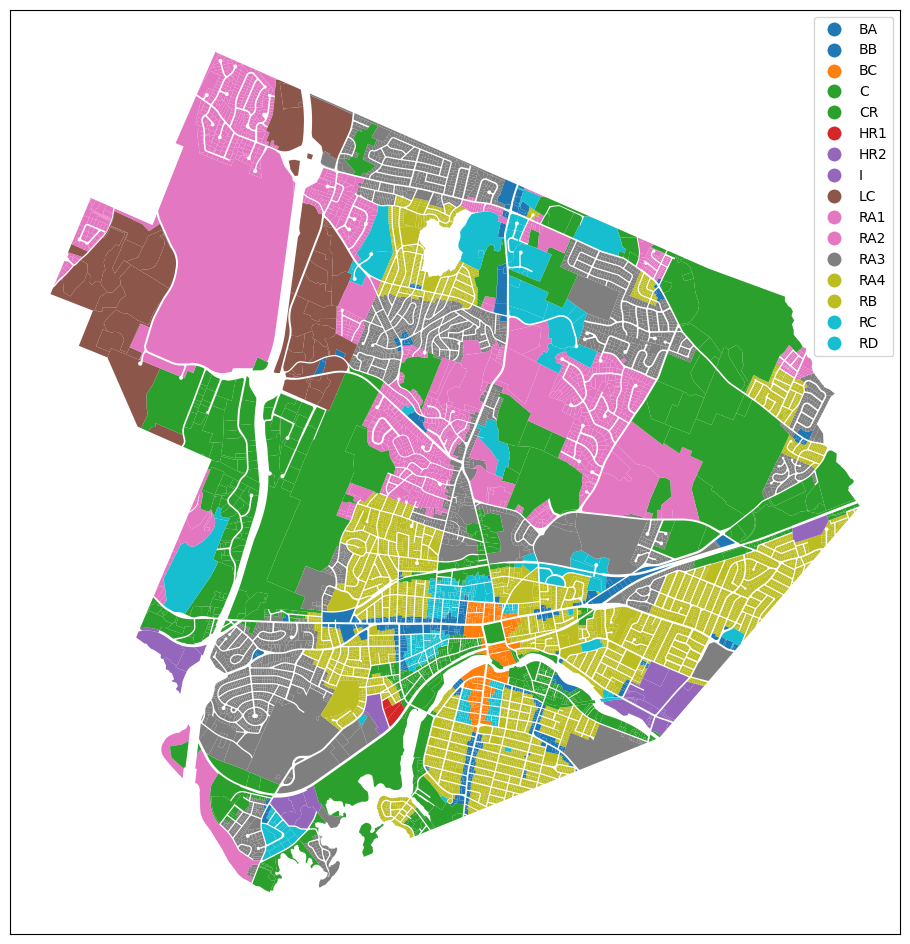

In [12]:
ax = zoned_parcels_df.plot(column="zone", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [13]:
# assign buildings to zones
zoned_buildings_df = buildings_df.sjoin(zoning_df, how="left", predicate="within")
zoned_buildings_df = zoned_buildings_df[["geom", "NAME", BLDG_FOOTPRINT_ACRE]]
zoned_buildings_df.rename(columns={"NAME": "zone"}, inplace=True)
zoned_buildings_df

geom zone  \
0      MULTIPOLYGON (((221761.404 902058.868, 221760....   RC   
1      MULTIPOLYGON (((220745.377 903053.674, 220730....   RB   
2      MULTIPOLYGON (((221283.985 901835.588, 221280....   RB   
3      MULTIPOLYGON (((221292.795 905675.213, 221285....  RA3   
4      MULTIPOLYGON (((221290.367 905779.246, 221283....  RA3   
...                                                  ...  ...   
16249  MULTIPOLYGON (((224299.988 903635.333, 224302....  RA4   
16250  MULTIPOLYGON (((224623.83 903572.723, 224626.9...  RA4   
16251  MULTIPOLYGON (((224622.55 903576.882, 224611.0...  RA4   
16252  MULTIPOLYGON (((224655.978 903495.312, 224650....  RA4   
16253  MULTIPOLYGON (((224668.613 903499.47, 224663.1...  RA4   

       BLDG_FOOTPRINT_ACRE  
0                 0.051775  
1                 0.054356  
2                 0.031126  
3                 0.025026  
4                 0.019577  
...                    ...  
16249             0.056705  
16250             0.030682  
16251             0.032314  
16252             0.028626  
16253             0.023134  

[16254 rows x 3 columns]

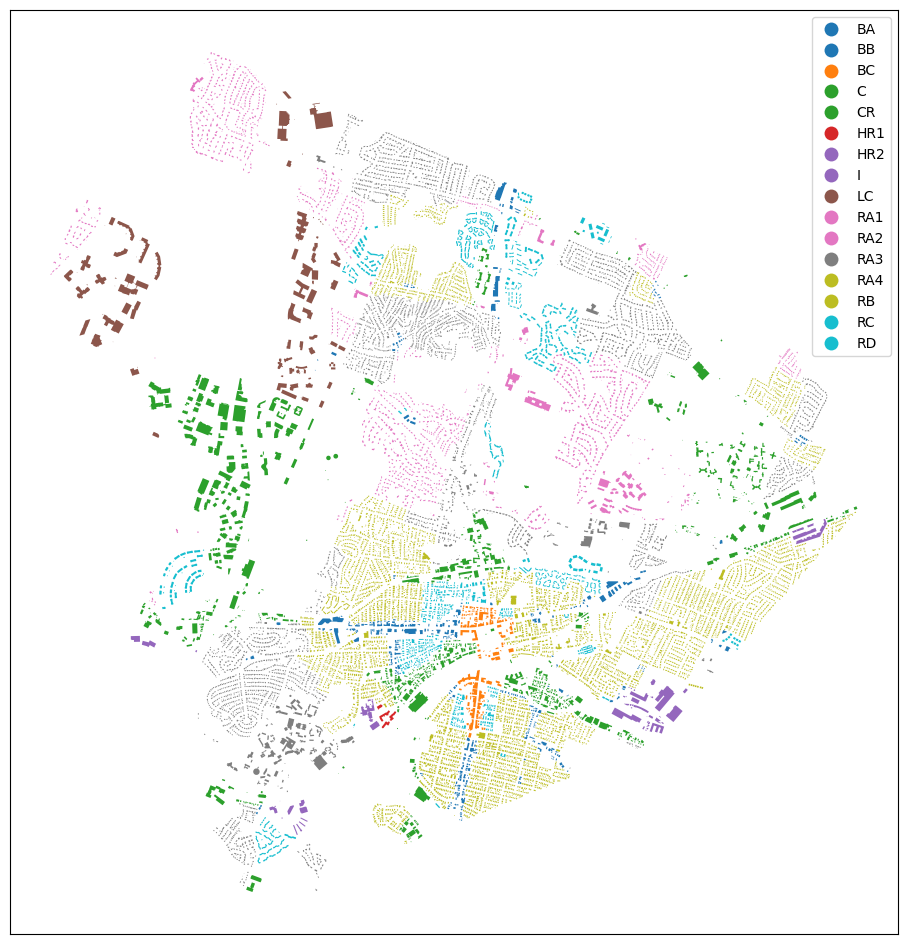

In [14]:
ax = zoned_buildings_df.plot(column="zone", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [15]:
# get the largest building on each parcel
zoned_buildings_df["geom"] = zoned_buildings_df.centroid

principal_bldgs_df = zoned_parcels_df.sjoin(zoned_buildings_df, how="right", predicate="contains")

In [16]:
# we want the largest building on a parcel, so we'll sort by LOC_ID, and then built out area descending
principal_bldgs_df.sort_values(by=["LOC_ID", BLDG_FOOTPRINT_ACRE], ascending=[True, False], inplace=True)
principal_bldgs_df.dropna(subset=["LOC_ID"], inplace=True)
principal_bldgs_df.drop_duplicates(subset=["LOC_ID"], keep="first", inplace=True)

In [17]:
principal_bldgs_df = principal_bldgs_df[["LOC_ID", BLDG_FOOTPRINT_ACRE]]

In [18]:
principal_bldgs_df

LOC_ID  BLDG_FOOTPRINT_ACRE
1414   F_714281_2972952             0.024312
8838   F_714362_2973054             0.047475
14997  F_714399_2973264             0.064689
12130  F_714449_2973138             0.040028
6134   F_714535_2973230             0.042209
...                 ...                  ...
4762   F_738551_2965680             0.028308
11939  F_738563_2965602             0.031165
5632   F_738576_2965643             0.015359
11295  F_738666_2965735             0.029563
3289   F_738687_2965867             0.171343

[12582 rows x 2 columns]

In [19]:
zoned_parcels_df = zoned_parcels_df.merge(principal_bldgs_df, on="LOC_ID", how="left")
zoned_parcels_df = zoned_parcels_df.merge(assessments_df, how="inner", on=["LOC_ID"])

# 101 is the single family use code in MassGIS
def get_sfh_mfh_groups(df):
    groups = {
        "single family": df[df["USE_CODE"] == 101],
        "multi family": df[df["USE_CODE"] != 101],
    }

    return groups


In [20]:
zoned_parcels_df.head()

LOC_ID                                               geom zone  \
0  F_720118_2954451  MULTIPOLYGON (((219510.406 900516.563, 219505....  RA3   
1  F_720144_2954524  MULTIPOLYGON (((219521.229 900544.743, 219512....  RA3   
2  F_720055_2954540  MULTIPOLYGON (((219481.807 900560.359, 219483....  RA3   
3  F_720183_2954604  MULTIPOLYGON (((219530.434 900568.77, 219524.3...  RA3   
4  F_720092_2954624  MULTIPOLYGON (((219500.999 900579.953, 219494....  RA3   

   PARCEL_AREA_ACRE  BLDG_FOOTPRINT_ACRE         SITE_ADDR  YEAR_BUILT  UNITS  \
0          0.103024             0.017571      759 SOUTH ST        1975      1   
1          0.216257             0.047155  753 -55 SOUTH ST        1860      2   
2          0.265953             0.027685      757 SOUTH ST        1975      1   
3          0.152051             0.019973      749 SOUTH ST        1960      1   
4          0.271934             0.024404      751 SOUTH ST        1975      1   

   RES_AREA STORIES  USE_CODE  BLD_AREA  assumed_height  
0      1612       2       101      1924          8.5344  
1      5677       3       104      7786         12.8016  
2       960       1       101      2018          4.2672  
3      1517       2       101      2759          8.5344  
4      1440       1       101      2168          4.2672

## Non-compliance

Parcels might not comply if they're too small. Structures wouldn't comply based on their shape or closeness to each other. FAR and setback violations turn out to be pretty hard to calculate so we'll skip that for now.

### Parcel size

Some zones have a minimum parcel size requirement.

In [21]:
def parcel_size(row):
    """
    returns True if the
    parcel is too small,
    False if there's no requirement
    or parcel is large enough
    """
    zone = row["zone"]
    min_lot_size = zoning_rules_df.at[zone, "lot area"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if min_lot_size == float('nan'):
        return False
    elif row[PARCEL_AREA_ACRE] == float('nan') or row[PARCEL_AREA_ACRE] == 0:
        return False
    
    return (row[PARCEL_AREA_ACRE] * SQ_FT_PER_ACRE < min_lot_size)

zoned_parcels_df[PARCEL_SIZE_TOO_SMALL] = zoned_parcels_df.apply(lambda row: parcel_size(row), axis="columns")

In [22]:
zoned_parcels_df[PARCEL_SIZE_TOO_SMALL].value_counts()

parcel_size_too_small
False    7819
True     7072
Name: count, dtype: int64

Text(0.5, 1.0, 'parcel is too small (52.51% in compliance)')

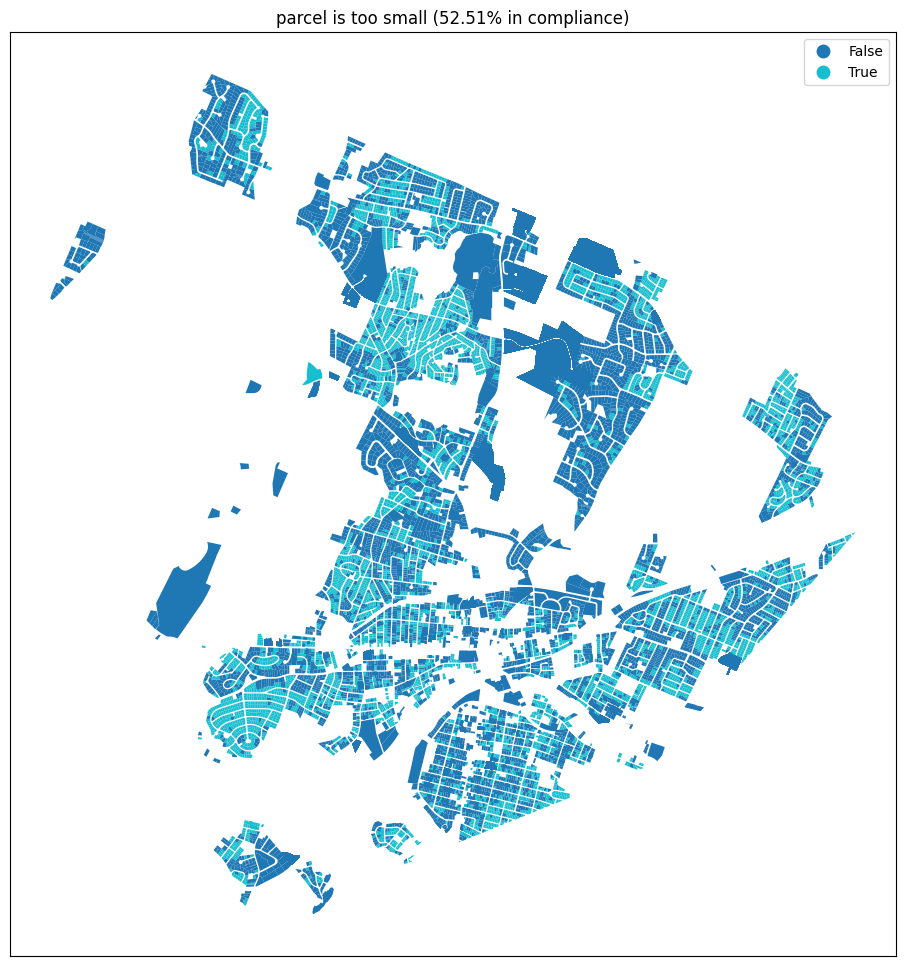

In [23]:
ax = zoned_parcels_df.plot(column=PARCEL_SIZE_TOO_SMALL, legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pct_in_compliance = 100*len(zoned_parcels_df[~zoned_parcels_df[PARCEL_SIZE_TOO_SMALL]]) / len(zoned_parcels_df)

ax.set_title(f"parcel is too small ({pct_in_compliance:.2f}% in compliance)")

### Impact by housing style

Since this is the single most impactful zoning requirement, how much does it affect our housing stock?

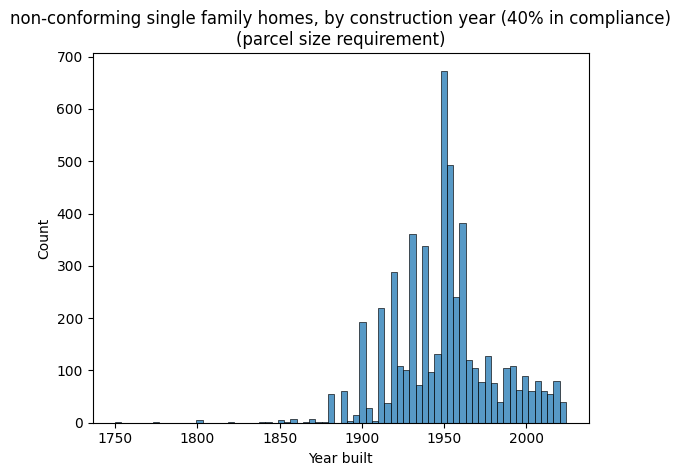

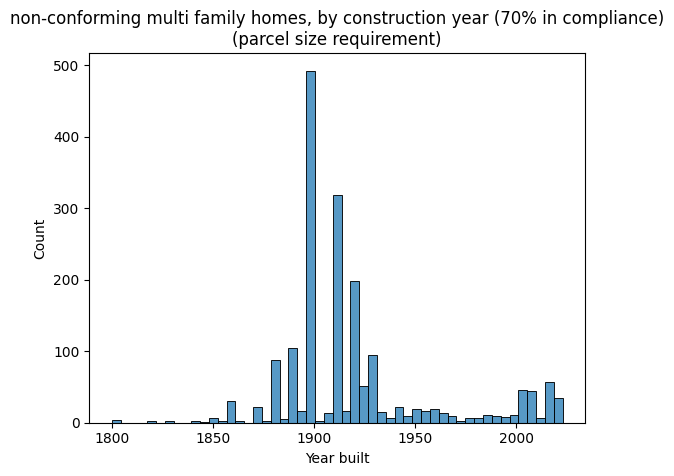

In [24]:

for name, filtered_df in get_sfh_mfh_groups(zoned_parcels_df).items():
    
    plt.figure()

    c = (filtered_df[PARCEL_SIZE_TOO_SMALL])

    ax = sns.histplot(
        filtered_df[c],
        x="YEAR_BUILT"
    )
    ax.set_xlabel("Year built")

    pct_in_compliance = 100 * len(filtered_df[~c]) / len(filtered_df)

    ax.set_title(f"non-conforming {name} homes, by construction year ({pct_in_compliance:0.0f}% in compliance)\n(parcel size requirement)")

### Too many stories

In [25]:
def stories_high(row):
    """
    returns True if the
    structure on the parcel
    has too many stories,
    False if there's no requirement
    """
    zone = row["zone"]
    allowed_stories = zoning_rules_df.at[zone, "stories"]

    # no requirement for this parcel
    if allowed_stories == float('nan') or allowed_stories == "":
        return False
    elif row["STORIES"] == float('nan') or row["STORIES"] == "" or not row["STORIES"]:
        return False

    return (float(row["STORIES"]) > float(allowed_stories))

zoned_parcels_df[STORIES_HIGH] = zoned_parcels_df.apply(lambda row: stories_high(row), axis=1)
zoned_parcels_df[STORIES_HIGH].value_counts()

stories_high
False    14703
True       188
Name: count, dtype: int64

Text(0.5, 1.0, 'built structure has too many stories (98.74% in compliance)')

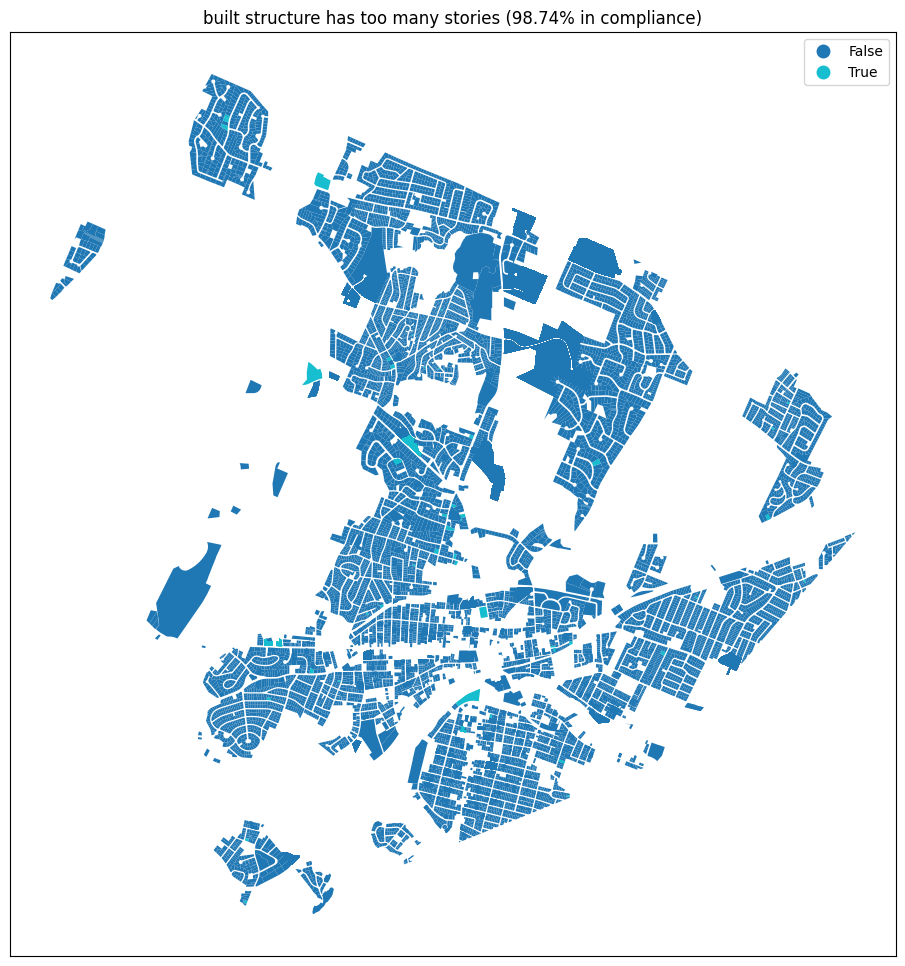

In [26]:
ax = zoned_parcels_df.plot(column=STORIES_HIGH, legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pct_in_compliance = 100*len(zoned_parcels_df[~zoned_parcels_df[STORIES_HIGH]]) / len(zoned_parcels_df)

ax.set_title(f"built structure has too many stories ({pct_in_compliance:.2f}% in compliance)")

### Dwelling units per acre too high

In [27]:
def too_many_units_per_acre(row):
    """
    returns True for high density,
    or residential structure type is
    forbidden
    """

    zone = row["zone"]
    max_dua = zoning_rules_df.at[zone, "max DUA"]
    as_built_units = row["UNITS"]
    lot_size = row[PARCEL_AREA_ACRE]
    
    # these rules aren't in the table, they're in the text of the code
    if "RA" in zone:
        return as_built_units > 1
    elif "RB" in zone:
        return as_built_units > 2
    elif zone in ["I", "C", "LC"]:
        return as_built_units > 0

    # no requirement for this parcel or parcel is somehow
    # zero size
    if pd.isna(max_dua) or max_dua == "":
        return False
    elif as_built_units == float('nan') or as_built_units == "" or lot_size == 0:
        return False

    return as_built_units / lot_size > max_dua

zoned_parcels_df[TOO_MANY_UNITS_PER_ACRE] = zoned_parcels_df.apply(lambda row: too_many_units_per_acre(row), axis=1)

In [28]:
zoned_parcels_df[TOO_MANY_UNITS_PER_ACRE].value_counts()

too_many_units_per_acre
False    12997
True      1894
Name: count, dtype: int64

Text(0.5, 1.0, 'built structure has too many units (87.28% in compliance)')

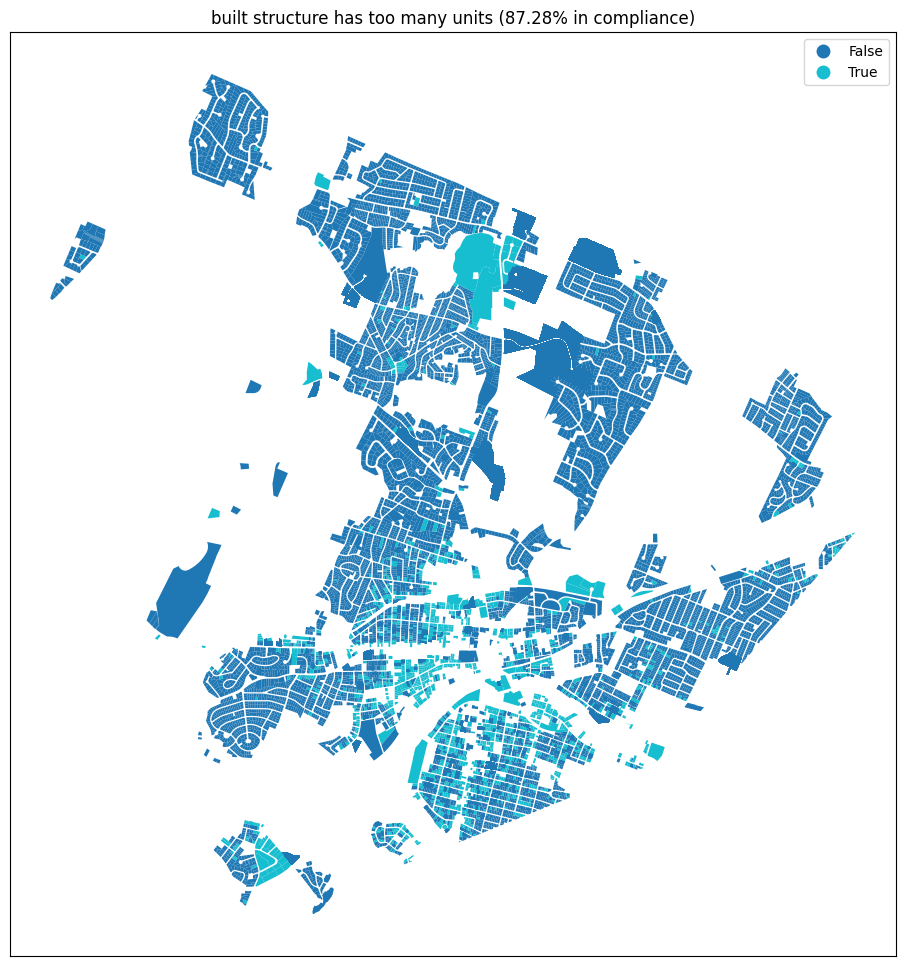

In [29]:
ax = zoned_parcels_df.plot(column=TOO_MANY_UNITS_PER_ACRE, legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pct_in_compliance = 100*len(zoned_parcels_df[~zoned_parcels_df[TOO_MANY_UNITS_PER_ACRE]]) / len(zoned_parcels_df)

ax.set_title(f"built structure has too many units ({pct_in_compliance:.2f}% in compliance)")

### Max lot coverage violations

In [30]:
def lot_coverage_too_high(row):
    """
    returns True if the lot coverage
    of the built structure is
    higher than allowed
    """


    zone = row["zone"]
    max_lot_coverage = zoning_rules_df.at[zone, "max lot coverage"]
    bld_area = row[BLDG_FOOTPRINT_ACRE]
    lot_size = row[PARCEL_AREA_ACRE]

    if pd.isna(max_lot_coverage) or max_lot_coverage == "":
        return {LOT_COVERAGE_HIGH: False, "coverage": 0.0}
    elif bld_area == float('nan') or bld_area == "":
        return {LOT_COVERAGE_HIGH: False, "coverage": 0.0}

    coverage = bld_area / lot_size
    return { LOT_COVERAGE_HIGH: coverage > max_lot_coverage, "coverage": coverage}

zoned_parcels_df[[LOT_COVERAGE_HIGH, "coverage"]] = zoned_parcels_df.apply(lambda row: lot_coverage_too_high(row), axis="columns", result_type="expand")

In [31]:
zoned_parcels_df[LOT_COVERAGE_HIGH].value_counts()

lot_coverage_too_high
False    12009
True      2882
Name: count, dtype: int64

Text(0.5, 1.0, 'lot coverage too high (80.65% in compliance)')

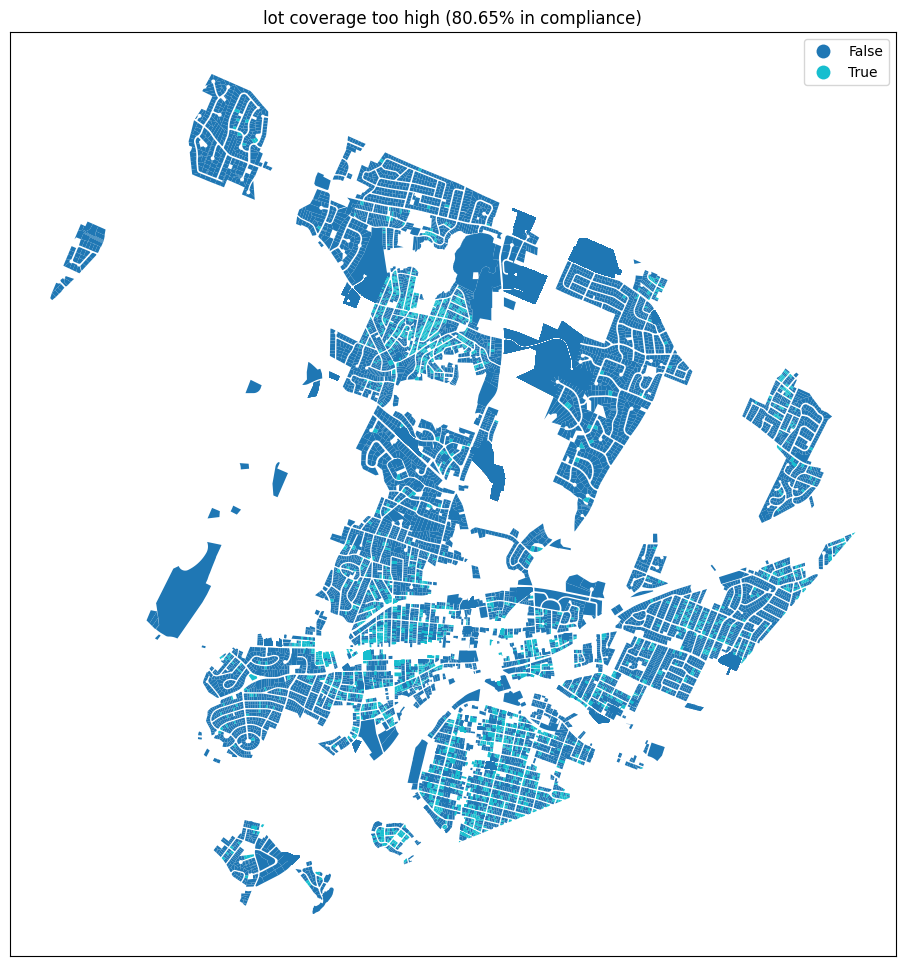

In [32]:
ax = zoned_parcels_df.plot(column=LOT_COVERAGE_HIGH, legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pct_in_compliance = 100*len(zoned_parcels_df[~zoned_parcels_df[LOT_COVERAGE_HIGH]]) / len(zoned_parcels_df)

ax.set_title(f"lot coverage too high ({pct_in_compliance:.2f}% in compliance)")

### FAR violations

(floor area ratio, another way to discourage massing)

In [33]:
def far_high(row):
    """
    returns True if the lot coverage
    of the built structure is
    higher than allowed
    """

    zone = row["zone"]
    far_limit = zoning_rules_df.at[zone, "FAR by right"]
    bld_area = row[BLDG_FOOTPRINT_ACRE]
    STORIES = row["STORIES"]
    lot_size = row[PARCEL_AREA_ACRE]

    if pd.isna(far_limit) or far_limit in["", 0] or lot_size == 0:
        return {FAR_HIGH: False, "far": 0.0}
    elif bld_area in [float('nan'), ""] or STORIES in [float('nan'), "", None]:
        return {FAR_HIGH: False, "far": 0.0}

    # assumes a perfectly extruded structure
    far = (bld_area * float(STORIES) / lot_size)
    
    return {FAR_HIGH: far > far_limit, "far": far}

zoned_parcels_df[[FAR_HIGH, "far"]] = zoned_parcels_df.apply(lambda row: far_high(row), axis='columns', result_type='expand')

In [34]:
zoned_parcels_df[FAR_HIGH].value_counts()

far_high
False    13394
True      1497
Name: count, dtype: int64

Text(0.5, 1.0, 'FAR too high (89.95% in compliance)')

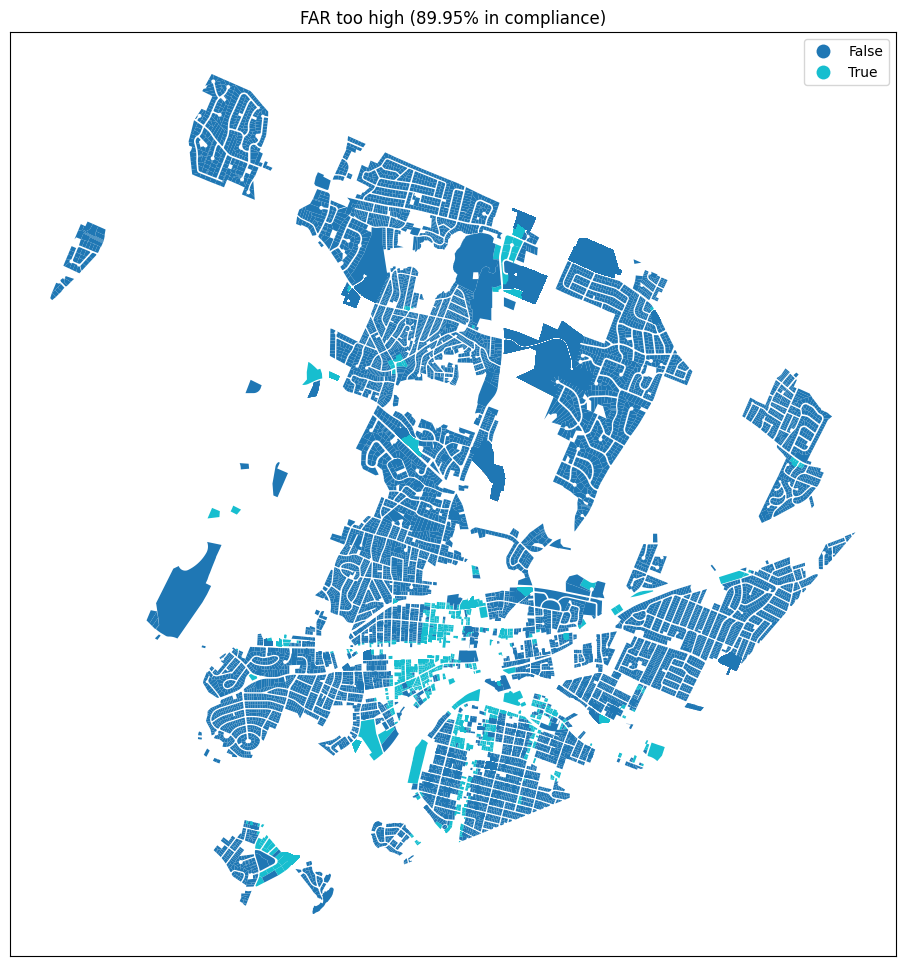

In [35]:
ax = zoned_parcels_df.plot(column=FAR_HIGH, legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pct_in_compliance = 100*len(zoned_parcels_df[~zoned_parcels_df[FAR_HIGH]]) / len(zoned_parcels_df)

ax.set_title(f"FAR too high ({pct_in_compliance:.2f}% in compliance)")

## All parcels that are illegal

(for any combination of zoning violations)

In [36]:
def any_violations(row):
    
    return row[PARCEL_SIZE_TOO_SMALL] or row[STORIES_HIGH] or row[TOO_MANY_UNITS_PER_ACRE] or row[FAR_HIGH] or row[LOT_COVERAGE_HIGH]

zoned_parcels_df[ANY_VIOLATIONS] = zoned_parcels_df.apply(lambda row: any_violations(row), axis=1, result_type='expand')

In [37]:
zoned_parcels_df[ANY_VIOLATIONS].value_counts()

any_violations
True     9024
False    5867
Name: count, dtype: int64

Text(0.5, 1.0, 'parcels with at least one violation (39.40% in compliance)')

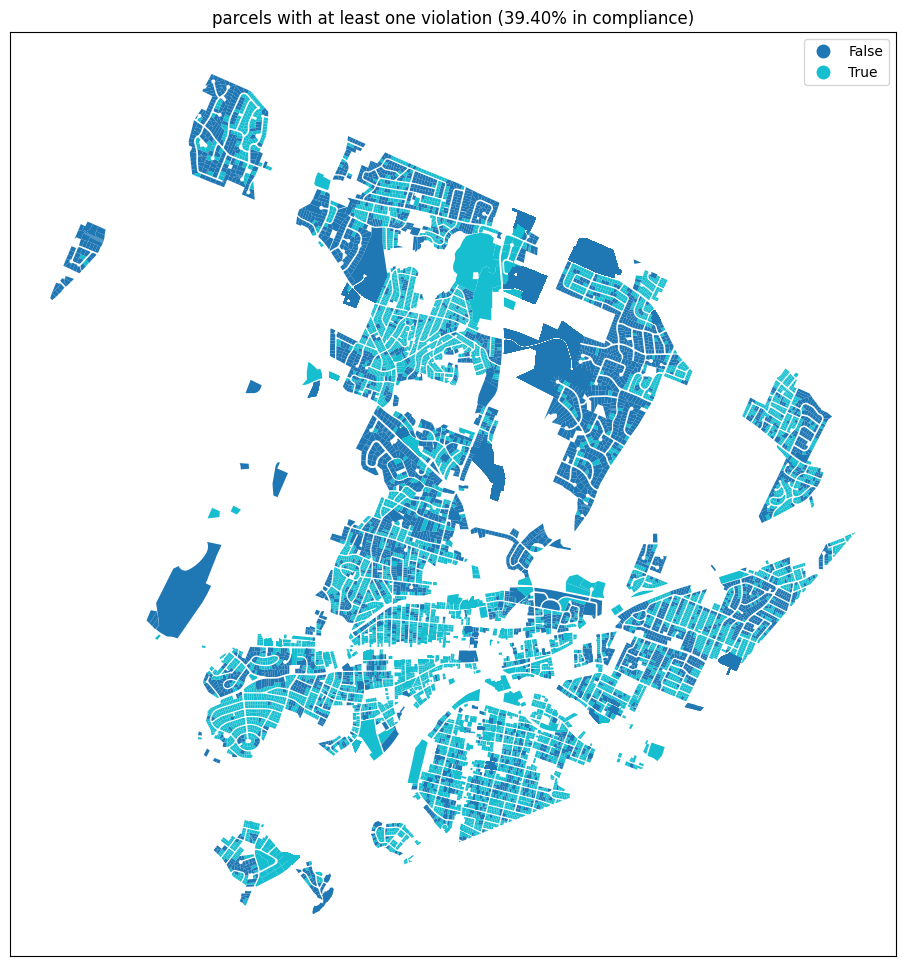

In [38]:
ax = zoned_parcels_df.plot(column=ANY_VIOLATIONS, legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pct_in_compliance = 100*len(zoned_parcels_df[~zoned_parcels_df[ANY_VIOLATIONS]]) / len(zoned_parcels_df)

ax.set_title(f"parcels with at least one violation ({pct_in_compliance:.2f}% in compliance)")


### The greatest scofflaws

Most non-conforming parcels in the city

In [39]:
def num_violations(row):
    
    return row[PARCEL_SIZE_TOO_SMALL] + row[STORIES_HIGH] + row[TOO_MANY_UNITS_PER_ACRE] + row[FAR_HIGH] + row[LOT_COVERAGE_HIGH]

zoned_parcels_df["num_violations"] = zoned_parcels_df.apply(lambda row: num_violations(row), axis=1, result_type='expand')

In [40]:
zoned_parcels_df["num_violations"].value_counts()

num_violations
0    5867
1    5643
2    2475
3     684
4     222
Name: count, dtype: int64

Text(0.5, 1.0, 'number of violations per parcel')

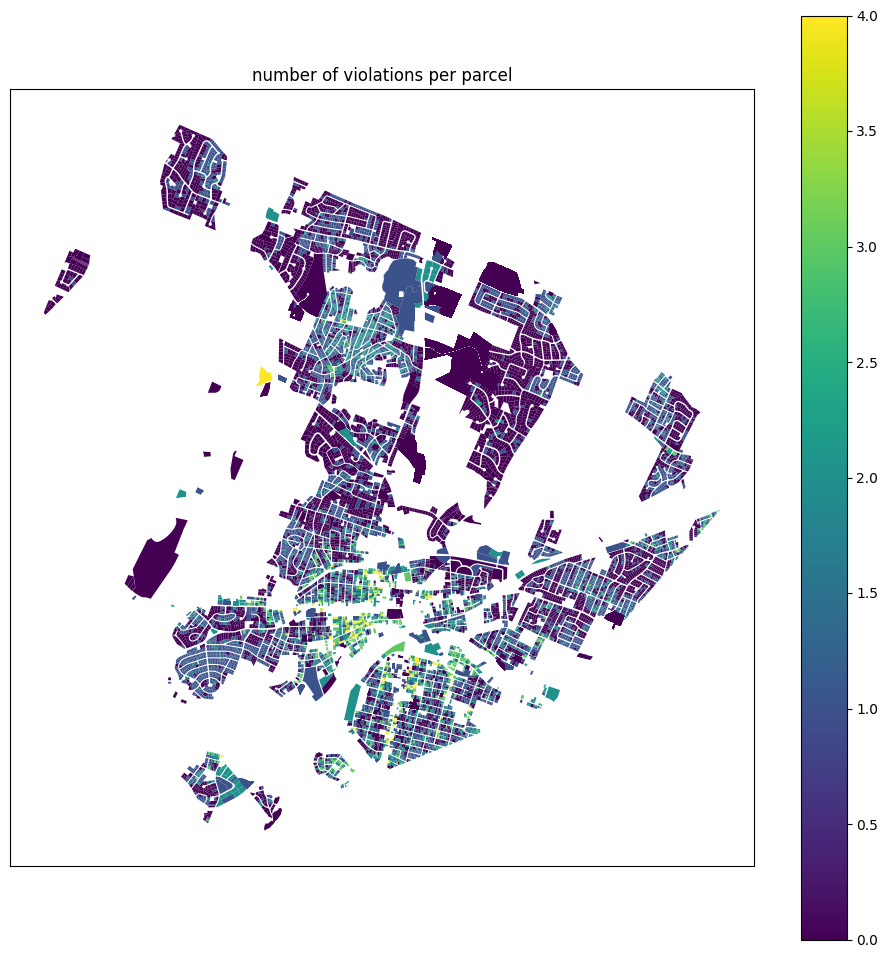

In [41]:
ax = zoned_parcels_df.plot(column="num_violations", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title(f"number of violations per parcel")

#### Violations by year built

What is the real character of the city? The older structures, or the newer ones?
Of course you would expect that newer structures would be more likely to be acceptable (since that was the whole point of the zoning),
but if you didn't have any bias against the older stock, you would have incorporated into the zoning code.

Text(0.5, 1.0, 'parcels with at least one violation, by construction year (39.40% in compliance)')

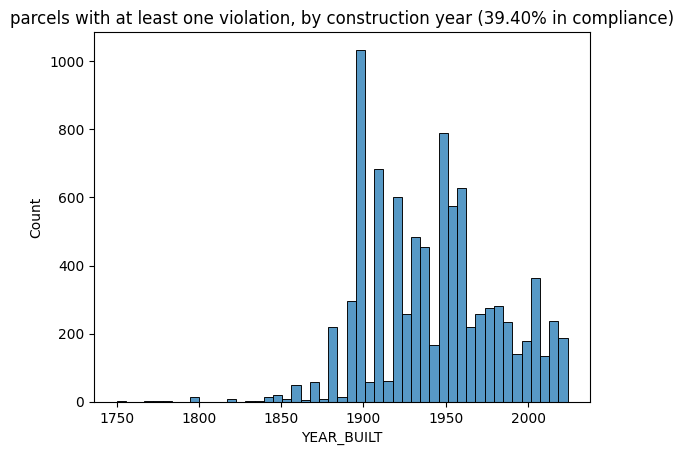

In [42]:
ax = sns.histplot(
    zoned_parcels_df[
        (zoned_parcels_df["YEAR_BUILT"] > 1740) & (zoned_parcels_df[ANY_VIOLATIONS])
    ], 
    x="YEAR_BUILT"
)

pct_in_compliance = 100 * len(zoned_parcels_df[~zoned_parcels_df[ANY_VIOLATIONS]]) / len(zoned_parcels_df)

ax.set_title(f"parcels with at least one violation, by construction year ({pct_in_compliance:.2f}% in compliance)")

... but if you were really caring about preserving the character of the city, why are there so many structures built before 1960 (and more than half of them!) not in compliance?

**Do we value the already built up environment, or not?**

#### Violations weighted by units built (i.e. units in parcels that have residential uses)

Some people live in SFH, but Waltham is 50% renters, so many of us live in MFH housing. Are most of us living in a non-conforming home?

In [43]:
# collect a record for each unit (there's probably a more efficient way to do this)

units_weighted = []
for index in range(len(zoned_parcels_df)):
    if int(zoned_parcels_df.at[index, "USE_CODE"]) > 200:
        # this isn't housing
        continue
    
    for _ in range(zoned_parcels_df.at[index, "UNITS"]):
        units_weighted.append({
            "YEAR_BUILT": zoned_parcels_df.at[index, "YEAR_BUILT"],
            ANY_VIOLATIONS: zoned_parcels_df.at[index, ANY_VIOLATIONS]
        })

df = pd.DataFrame(units_weighted)

Text(0.5, 1.0, 'units in parcels with violations, by construction year (27% in compliance)')

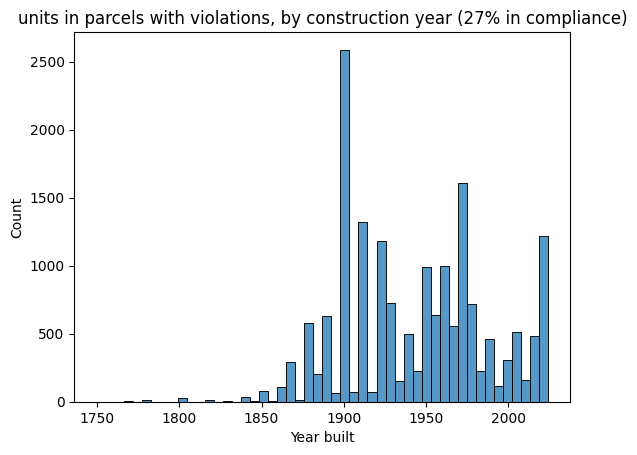

In [44]:
ax = sns.histplot(
    df[df[ANY_VIOLATIONS]], 
    x="YEAR_BUILT"
)
ax.set_xlabel("Year built")

pct_in_compliance = 100 * len(df[~df[ANY_VIOLATIONS]]) / len(df)

ax.set_title(f"units in parcels with violations, by construction year ({pct_in_compliance:0.0f}% in compliance)")

It seems quite plausible that most of us are living in non-conforming dwellings (one would need per-unit population to be sure).

#### Violations by structure type

Did the zoning even do a good job of protecting the character of existing single family homes?

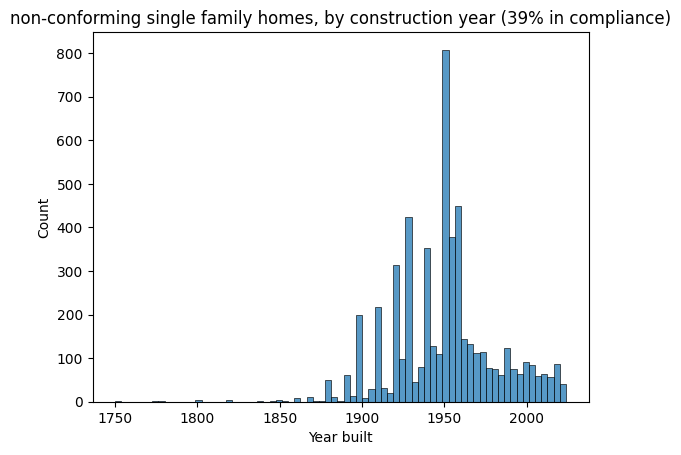

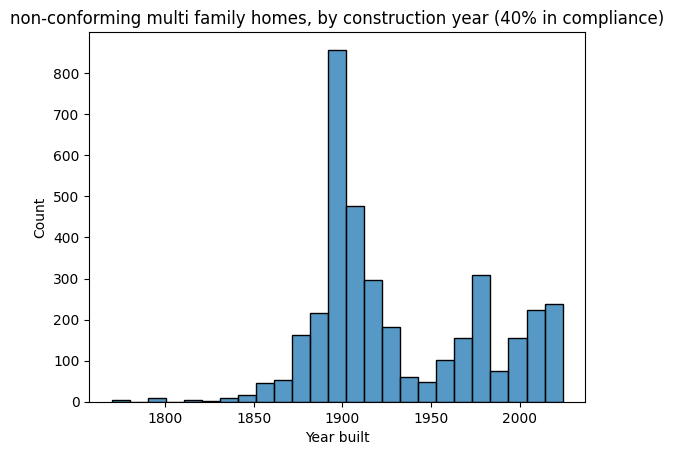

In [45]:

for name, filtered_df in get_sfh_mfh_groups(zoned_parcels_df).items():
    
    plt.figure()

    c = (filtered_df[ANY_VIOLATIONS])

    ax = sns.histplot(
        filtered_df[c],
        x="YEAR_BUILT"
    )
    ax.set_xlabel("Year built")

    pct_in_compliance = 100 * len(filtered_df[~c]) / len(filtered_df)

    ax.set_title(f"non-conforming {name} homes, by construction year ({pct_in_compliance:0.0f}% in compliance)")

I'm not sure what happened with 1950's single family homes, but I guess we really don't want them around anymore. We built a bunch and then a few decades later, decided to apply rules so we can't build like that anymore.

Ironically, we actually do a (very slightly) better job of compliance with multi-family housing, but probably only because we banned them very early.

# The chilling effect on development

What happened to the rate of construction of housing units over time? What does this situation look like for MFH vs. SFH? By single structure, and by unit?

Text(0.5, 0, 'year built')

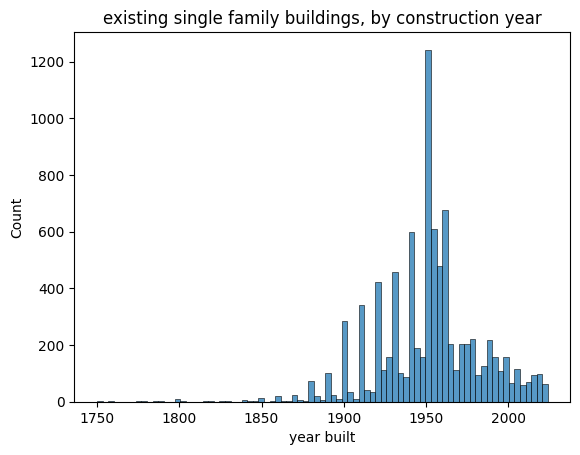

In [46]:
temp_df = assessments_df[assessments_df["USE_CODE"] == 101]    

ax = sns.histplot(
        temp_df,
        x="YEAR_BUILT"
)
ax.set_title(f"existing single family buildings, by construction year")
ax.set_xlabel("year built")

Text(0.5, 0, 'year built')

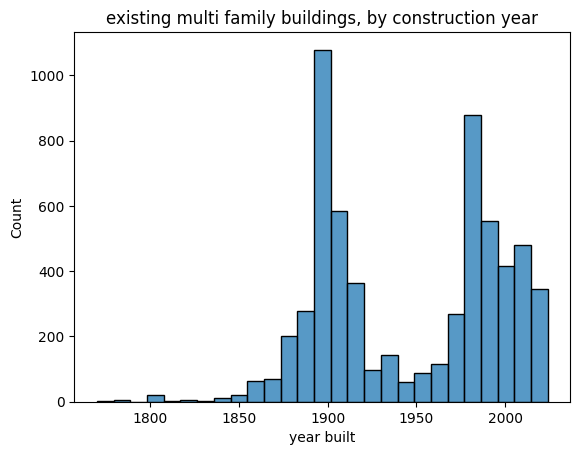

In [47]:
temp_df = assessments_df[(assessments_df["USE_CODE"] < 200) & (assessments_df["USE_CODE"] != 101)]  

ax = sns.histplot(
        temp_df,
        x="YEAR_BUILT"
)
ax.set_title(f"existing multi family buildings, by construction year")
ax.set_xlabel("year built")

Text(0.5, 0, 'year built')

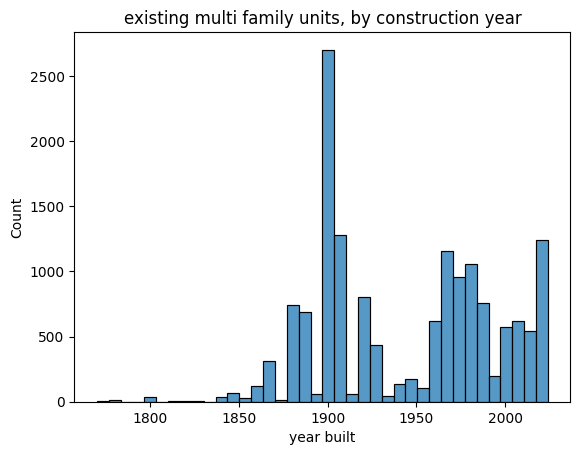

In [48]:
temp_df = assessments_df[(assessments_df["USE_CODE"] < 200) & (assessments_df["USE_CODE"] != 101)]
records = []
for index in temp_df.index:
    for _ in range(temp_df.at[index, "UNITS"]):
        records.append({
            "YEAR_BUILT": temp_df.at[index, "YEAR_BUILT"]
        })
        
temp_df = pd.DataFrame(records)
ax = sns.histplot(
        temp_df,
        x="YEAR_BUILT"
)
ax.set_title(f"existing multi family units, by construction year")
ax.set_xlabel("year built")

## Upload data

This isn't part of the analysis, I'm just saving the data to my database and generating an offline map.

In [49]:
zoned_parcels_df.to_postgis("illegal_zoning", con, if_exists="replace")

In [50]:
# prepare for mapping by converting to a lat/lon CRS
zoned_parcels_df.to_crs("EPSG:4326", inplace=True)

# purge some unneeded columns
map_df = zoned_parcels_df[["geom", "SITE_ADDR", LOT_COVERAGE_HIGH, STORIES_HIGH, TOO_MANY_UNITS_PER_ACRE, PARCEL_SIZE_TOO_SMALL, ANY_VIOLATIONS, FAR_HIGH, "far", "coverage"]]

In [51]:
center = [42.3, -71.2]
bounds = map_df.total_bounds.tolist()
m = folium.Map(
    location=center,
    zoom_start=10,
    tiles="cartodbpositron",
    max_bounds=True,
    min_lat=42.2,
    max_lat=42.5,
    min_long=-72,
    max_long=-71,
    max_width=800,
    prefer_canvas=True
)

# TODO:
# is there anyway to restrict the actual panning bounds of the map?
m.fit_bounds([bounds[:2][::-1], bounds[2:][::-1]])

tooltip = folium.GeoJsonTooltip(
    fields=[
        "SITE_ADDR",
        PARCEL_SIZE_TOO_SMALL,
        STORIES_HIGH,
        TOO_MANY_UNITS_PER_ACRE,
        LOT_COVERAGE_HIGH,
        "coverage",
        FAR_HIGH,
        "far"
    ],
    aliases=[
        "Address",
        "Parcel is too small",
        "Too many stories",
        "Too many units on parcel",
        "Lot coverage too high",
        "coverage",
        "FAR too high",
        "far"
    ],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    min_zoom=2,
)

def fill_rule(feature):
    return {
        "fillColor": "red" if feature["properties"][ANY_VIOLATIONS] == 1 else "green",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.2,
    }


parcels_geo = folium.GeoJson(
    map_df, style_function=lambda feature: fill_rule(feature), tooltip=tooltip
).add_to(m)

addr_search = Search(
    layer=parcels_geo,
    geom_type="Polygon",
    placeholder="Search by address",
    collapsed=False,
    search_label="SITE_ADDR",
    weight=3,
).add_to(m)

In [52]:

# uncomment to show - usually makes the file too big to show in github though
# m

In [54]:
os.makedirs("published", exist_ok=True)
m.save("published/illegal_zoning.html", bounds=(bounds[:2][::-1] + bounds[2:][::-1]), maxBoundsViscosity=1.0)